# Create Location Object & Relationships

This notebook processes location sensor data to create behavior events and objects that represent a user's location patterns. The process involves:

1. Identifying when a user enters or exits specific locations (geofences)
2. Detecting when a user is in transit between locations
3. Creating location segments that represent stays at different locations
4. Linking these events and objects to the original sensor data


## 1. Setup

In [1]:
import pandas as pd
import sys
sys.path.append('..')
import pandas as pd
import json
from datetime import datetime, timedelta
from pathlib import Path
from src.oced.location_objects import LocationEventManager
from src.oced.time_objects import TimeObject
import matplotlib.pyplot as plt
import seaborn as sns
from src.oced.oced_data_query import OCEDDataQuery


# 2. Load OCED Data
First, we load the OCED data and extract the location sensor events. These events contain:
- Timestamp
- Latitude and longitude coordinates
- Additional sensor data (altitude, speed, error)

In [2]:
# Get OCED-mHealth Data from JSON File
dataQuery = OCEDDataQuery()  
oced_data_file = f"player_107631_oced_data_time_bouts_notifications_stress.json"
data_dict = dataQuery.load_json(oced_data_file)

# Quick look at the data structure
print(f"Number of behavior events: {len(data_dict.get('behaviorEvents', []))}")
print(f"Number of objects: {len(data_dict.get('objects', []))}")

# Diagnostic code to inspect notification events
location_sensor_events = [
    notif for notif in data_dict.get('sensorEvents', [])
    if notif['sensorEventType'] == 'location'
]

print(f"Number of location sensor events: {len(location_sensor_events)}")
location_sensor_events

Number of behavior events: 498
Number of objects: 349
Number of location sensor events: 12903


[{'id': '109085bf-9c19-4c2a-8792-1bfaba12b242',
  'sensorEventType': 'location',
  'time': '2025-05-25T14:02:22',
  'sensorEventTypeAttributes': [{'name': 'latitude',
    'value': 52.09357452392578},
   {'name': 'longitude', 'value': 5.111295223236084},
   {'name': 'altitude', 'value': 46.5},
   {'name': 'speed', 'value': 5.576400089263916},
   {'name': 'error', 'value': 11.0}],
  'relationships': [{'id': 'd360ac20-326e-4f6f-8113-baa47ef536ef',
    'type': 'object',
    'qualifier': 'source'},
   {'id': '8d47453a-6a5c-454d-806a-971b71a11d8f',
    'type': 'object',
    'qualifier': 'occurred_on'}],
  'event_type': 'sensor'},
 {'id': 'aecf014a-d1e5-47a2-ae2d-90f4d8ef8567',
  'sensorEventType': 'location',
  'time': '2025-05-25T14:01:22',
  'sensorEventTypeAttributes': [{'name': 'latitude',
    'value': 52.09409713745117},
   {'name': 'longitude', 'value': 5.11100435256958},
   {'name': 'altitude', 'value': 48.59999847412109},
   {'name': 'speed', 'value': 5.612400054931641},
   {'name': 

## 3. Define Location Geofences

Location geofences define the boundaries of important locations. Each geofence has:
- A unique name (e.g., "home", "work")
- Center coordinates (latitude, longitude)
- Radius in meters

These geofences will be used to determine when a user enters or exits these locations.

In [ ]:
location_geofences = {
    'home': {
        'latitude': 52.09733976415986, 
        'longitude': 5.109440239875549,
        'radius': 50  # meters
    },
    'work': {
        'latitude': 51.44792083437223,
        'longitude': 5.486085861578487,
        'radius': 200
    },
    'gym': {
        'latitude': 52.09881115258374,
        'longitude': 5.11129722583215,
        'radius': 50
    }
}

# Visualize geofences on a map
def plot_geofences(geofences):
    plt.figure(figsize=(10, 10))
    
    # Plot each geofence
    for name, geofence in geofences.items():
        plt.scatter(geofence['longitude'], geofence['latitude'], 
                   label=name, s=geofence['radius']*2)
    
    plt.title('Location Geofences')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_geofences(location_geofences)

## 4. Process Location Sensor Events Data

#### 4.1. Initializes the LocationEventManager

In [4]:
location_manager = LocationEventManager()

#### 4.2. Creates necessary event and object types

In [5]:
# Create event types
print("Creating location event types...")
data_with_types = location_manager.create_location_event_type(data_dict)
event_types = [type for type in data_dict.get('behaviorEventTypes', [])]
event_types

Creating location event types...


[{'name': 'mood',
  'attributes': [{'name': 'valence', 'type': 'number'},
   {'name': 'arousal', 'type': 'number'},
   {'name': 'stress', 'type': 'number'}]},
 {'name': 'notification',
  'attributes': [{'name': 'action', 'type': 'string'}]},
 {'name': 'physical_activity_bout',
  'attributes': [{'name': 'lifecycle', 'type': 'string'},
   {'name': 'bout_type', 'type': 'string'}]},
 {'name': 'location_event',
  'attributes': [{'name': 'lifecycle', 'type': 'string'},
   {'name': 'location_type', 'type': 'string'}]}]

In [6]:
# Create object types
print("Creating location object types...")
data_with_types = location_manager.create_location_object_type(data_with_types)
object_types = [type for type in data_with_types.get('objectTypes', [])]
object_types

Creating location object types...


[{'name': 'player', 'attributes': [{'name': 'id', 'type': 'string'}]},
 {'name': 'intervention',
  'attributes': [{'name': 'goal', 'type': 'string'},
   {'name': 'start_date', 'type': 'string'},
   {'name': 'end_date', 'type': 'string'}]},
 {'name': 'day',
  'attributes': [{'name': 'date', 'type': 'string'},
   {'name': 'day_of_week', 'type': 'string'}]},
 {'name': 'week',
  'attributes': [{'name': 'week_start_date', 'type': 'string'},
   {'name': 'week_number', 'type': 'integer'},
   {'name': 'year', 'type': 'integer'}]},
 {'name': 'physical_activity_bout',
  'attributes': [{'name': 'bout_type', 'type': 'string'}]},
 {'name': 'notification',
  'attributes': [{'name': 'last_action', 'type': 'string'}]},
 {'name': 'stress_self_report',
  'attributes': [{'name': 'stress_value', 'type': 'number'}]},
 {'name': 'location_segment',
  'attributes': [{'name': 'location_type', 'type': 'string'},
   {'name': 'start_time', 'type': 'string'},
   {'name': 'end_time', 'type': 'string'}]}]

#### 4.3. Processes sensor events to create location events and segments

In [7]:
# Get location sensor events
sensor_events = [event for event in data_with_types.get('sensorEvents', [])
                    if event.get('sensorEventType') == 'location']
print(f"Found {len(sensor_events)} location sensor events")

# Get the user ID from the data
user_objects = [obj for obj in data_with_types.get('objects', []) if obj['type'] == 'player']
if not user_objects:
    raise ValueError("No user object found in the data")
user_id = user_objects[0]['id']
print(f"Using user ID: {user_id}")
    
# Create location events and objects
print("Creating location events and segments...")
extended_data, location_events = location_manager.create_location_events_and_objects(
    data=data_with_types,
    sensor_events=sensor_events,
    user_id=user_id,
    location_geofences=location_geofences,
    transit_distance_threshold=50.0,  # meters
    transit_time_threshold=timedelta(minutes=2),
    min_segment_duration=timedelta(minutes=5),
    invalid_gps_duration_threshold=timedelta(minutes=300),
    default_home_geofence="home"
    )
import pandas as pd
location_events_df = pd.DataFrame(location_events)
location_events_df.to_json('LIGHT_bouts.json', orient='records', indent=4)

# Print statistics
print("\nStatistics:")
print(f"Total location events created: {len(location_events)}")
print(f"Total location segments created: {len(location_manager.location_objects)}")

location_manager.location_objects

Found 9366 location sensor events
Using user ID: e4365330-3468-48c3-bce3-145668e06f8f
Creating location events and segments...

Statistics:
Total location events created: 492
Total location segments created: 246


{'34a82dad-8796-4a32-9721-4a329f2f2c5a': {'id': '34a82dad-8796-4a32-9721-4a329f2f2c5a',
  'type': 'location_segment',
  'attributes': [{'name': 'location_type',
    'value': 'invalid',
    'time': '2025-05-20T08:38:53'},
   {'name': 'start_time',
    'value': '2025-05-20 08:38:53',
    'time': '2025-05-20T08:38:53'},
   {'name': 'end_time',
    'value': '2025-05-20 08:47:57',
    'time': '2025-05-20T08:47:57'}],
  'relationships': [{'type': 'behaviorEvent',
    'id': '4dea7a65-c2a9-4045-8baf-39fc218adda4',
    'qualifier': 'enters'},
   {'type': 'behaviorEvent',
    'id': '6227b9dd-cf8b-45d9-8a0a-3bcfddf5a0fb',
    'qualifier': 'exits'},
   {'type': 'object',
    'id': 'e4365330-3468-48c3-bce3-145668e06f8f',
    'qualifier': 'performed_by'},
   {'type': 'object',
    'id': '0b172a12-c9eb-4e98-8331-a5d430703bf6',
    'qualifier': 'occurred_on'}]},
 '37c34630-d3ab-4cbe-8d1b-f2a5edb32ec3': {'id': '37c34630-d3ab-4cbe-8d1b-f2a5edb32ec3',
  'type': 'location_segment',
  'attributes': [{'name

## 5. Create visualizations
We'll create two visualization functions:
1. A function to get events and segments for a specific day
2. A function to create the actual visualization plots

The visualization will show:
- Location events (Entering/Exiting) on a timeline
- Location segments as horizontal bars
- Different colors for different location types
- Time information for each event and segment

In [8]:
def get_day_events(extended_data, date_str):
    """Get all events and segments for a specific day."""
    day_events = {
        'sensor': [],
        'behavior': []
    }
    
    # Filter sensor events
    for event in extended_data.get('sensorEvents', []):
        event_time = datetime.fromisoformat(event['time'].replace('Z', '+00:00'))
        if event_time.strftime('%Y-%m-%d') == date_str:
            day_events['sensor'].append(event)
    
    # Filter behavior events (location events)
    for event in extended_data.get('behaviorEvents', []):
        if event['behaviorEventType'] == 'location_event':
            event_time = datetime.fromisoformat(event['time'].replace('Z', '+00:00'))
            if event_time.strftime('%Y-%m-%d') == date_str:
                day_events['behavior'].append(event)
    
    # Get location segments
    day_segments = []
    for obj in extended_data.get('objects', []):
        if obj['type'] == 'location_segment':
            start_time = datetime.fromisoformat(next(attr['value'] for attr in obj['attributes'] 
                                                   if attr['name'] == 'start_time'))
            if start_time.strftime('%Y-%m-%d') == date_str:
                day_segments.append(obj)
    
    return day_events, day_segments

def visualize_location_day(extended_data, date_str, location_geofences):
    """Create visualization of location events and segments for a specific day."""
    # Get events and segments for the day
    day_events, day_segments = get_day_events(extended_data, date_str)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[1, 2])
    
    # Plot 1: Location events
    event_types = ['Entering', 'Exiting']
    colors = {'Entering': 'green', 'Exiting': 'red'}
    
    for event in day_events['behavior']:
        event_time = datetime.fromisoformat(event['time'].replace('Z', '+00:00'))
        lifecycle = next(attr['value'] for attr in event['attributes'] 
                        if attr['name'] == 'lifecycle')
        location_type = next(attr['value'] for attr in event['attributes'] 
                           if attr['name'] == 'location_type')
        
        # Plot event
        ax1.scatter(event_time, 0, color=colors[lifecycle], marker='|', s=100)
        ax1.text(event_time, 0.1, f"{lifecycle}\n{location_type}", 
                rotation=45, ha='right', va='bottom')
    
    ax1.set_title('Location Events')
    ax1.set_yticks([])
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Location segments
    segment_types = sorted(set(segment['attributes'][0]['value'] 
                             for segment in day_segments))
    colors = plt.cm.Set3(np.linspace(0, 1, len(segment_types)))
    color_map = dict(zip(segment_types, colors))
    
    for i, segment in enumerate(day_segments):
        start_time = datetime.fromisoformat(next(attr['value'] for attr in segment['attributes'] 
                                               if attr['name'] == 'start_time'))
        end_time = datetime.fromisoformat(next(attr['value'] for attr in segment['attributes'] 
                                             if attr['name'] == 'end_time'))
        location_type = next(attr['value'] for attr in segment['attributes'] 
                           if attr['name'] == 'location_type')
        
        # Plot segment
        ax2.barh(i, (end_time - start_time).total_seconds() / 3600, 
                left=start_time.hour + start_time.minute/60,
                color=color_map[location_type], alpha=0.7)
        ax2.text(start_time.hour + start_time.minute/60, i, 
                f"{location_type}\n{start_time.strftime('%H:%M')}-{end_time.strftime('%H:%M')}",
                va='center')
    
    ax2.set_title('Location Segments')
    ax2.set_xlabel('Hour of Day')
    ax2.set_yticks([])
    ax2.set_xlim(0, 24)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

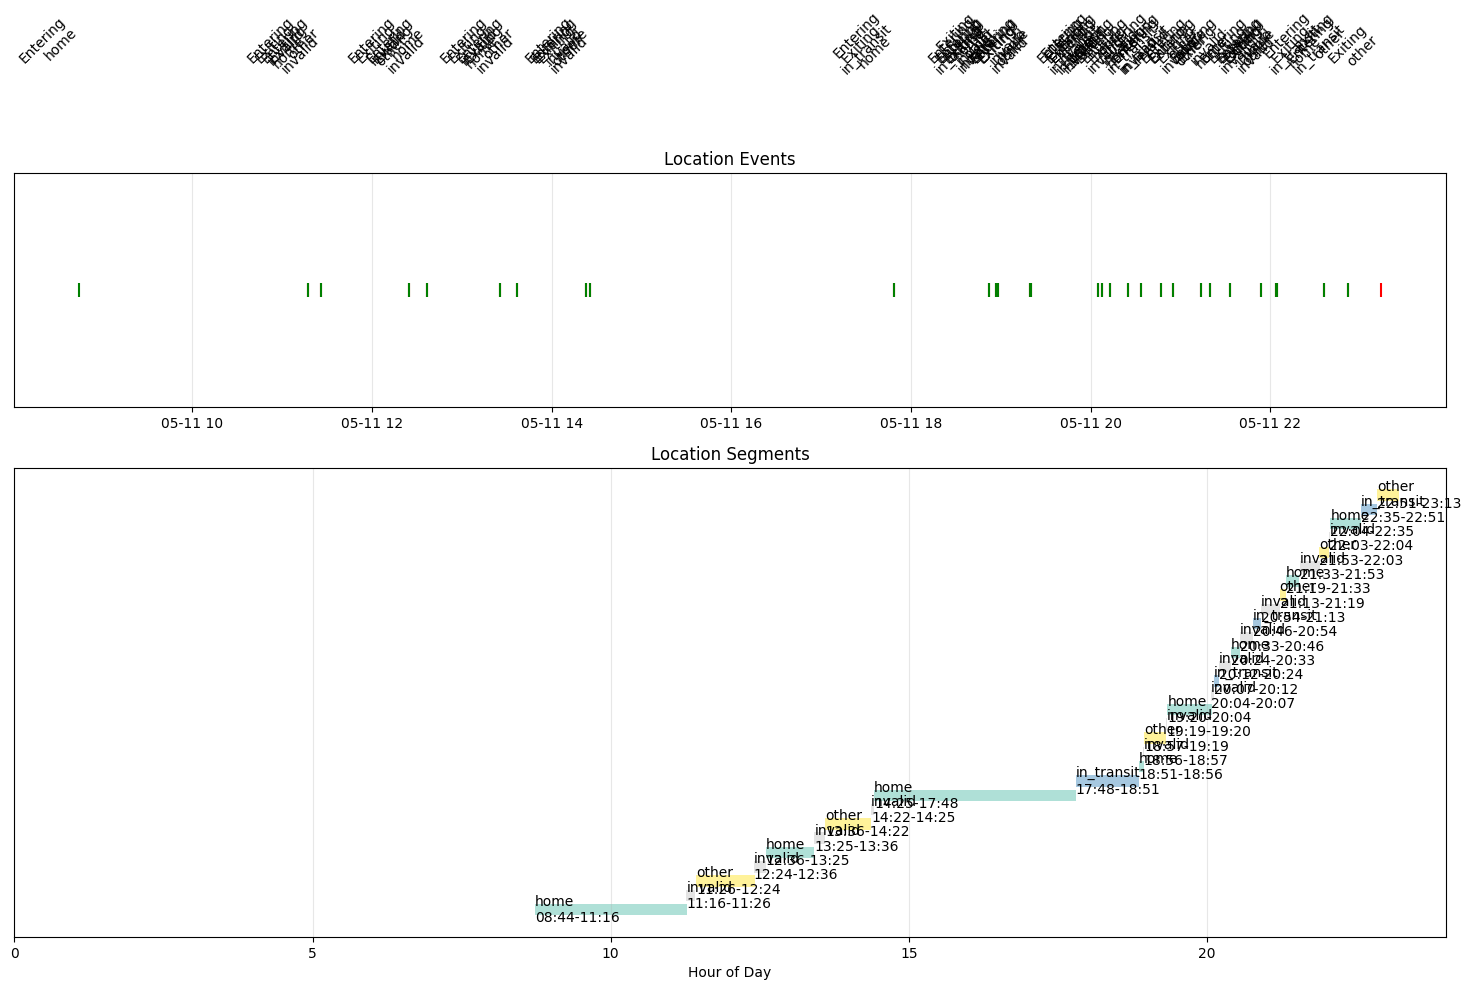

In [9]:
date_to_visualize = "2025-05-11"  # Replace with actual date
import numpy as np
fig = visualize_location_day(extended_data, date_to_visualize, location_geofences)
plt.show()


## Diagnostics 

In [10]:
def analyze_location_data(extended_data, location_manager):
    """Analyze location events and segments to understand their relationship."""
    # Get all location events
    location_events = [event for event in extended_data.get('behaviorEvents', [])
                      if event['behaviorEventType'] == 'location_event']
    
    # Count events by type
    entering_events = [e for e in location_events 
                      if next(attr['value'] for attr in e['attributes'] 
                             if attr['name'] == 'lifecycle') == 'Entering']
    exiting_events = [e for e in location_events 
                     if next(attr['value'] for attr in e['attributes'] 
                            if attr['name'] == 'lifecycle') == 'Exiting']
    
    # Get all segments
    segments = [obj for obj in extended_data.get('objects', [])
               if obj['type'] == 'location_segment']
    
    # Analyze relationships
    print(f"Total location events: {len(location_events)}")
    print(f"  - Entering events: {len(entering_events)}")
    print(f"  - Exiting events: {len(exiting_events)}")
    print(f"Total location segments: {len(segments)}")
    
    # Check for orphaned events (events not linked to segments)
    orphaned_events = []
    for event in location_events:
        event_id = event['id']
        is_linked = False
        for segment in segments:
            if any(rel['behaviorEvent'] == event_id 
                  for rel in segment.get('relationships', [])):
                is_linked = True
                break
        if not is_linked:
            orphaned_events.append(event)
    
    print(f"\nOrphaned events (not linked to any segment): {len(orphaned_events)}")
    if orphaned_events:
        print("Example orphaned event:")
        print(json.dumps(orphaned_events[0], indent=2))
    
    # Check for segments with missing events
    incomplete_segments = []
    for segment in segments:
        has_enter = False
        has_exit = False
        for rel in segment.get('relationships', []):
            if rel['type'] == 'starts_with':
                has_enter = True
            elif rel['type'] == 'ends_with':
                has_exit = True
        if not (has_enter and has_exit):
            incomplete_segments.append(segment)
    
    print(f"\nSegments with missing events: {len(incomplete_segments)}")
    if incomplete_segments:
        print("Example incomplete segment:")
        print(json.dumps(incomplete_segments[0], indent=2))

print("\nAnalyzing location events and segments...")
#analyze_location_data(extended_data, location_manager)


Analyzing location events and segments...


## 7. Add relationships with objects and events

#### 7.1. Add relationships to Physical Activity Bout Objects and Events

In [11]:
# Get all PA bout objects from extended_data
pa_bout_objects = [
    obj for obj in extended_data.get('objects', [])
    if obj['type'] == 'physical_activity_bout'  # Adjust this if your PA bout type has a different name
]
# First, relate PA bout events to locations and then bout objects to locations
updated_data = location_manager.relate_location_to_pa_bouts(
    extended_data,
    pa_bout_objects
)

Found 6 bouts with associated events
Bout 0ee6d279-7790-4c44-9c34-d3f437d7b7ac has 2 events
  Event 5988e26e-8304-457f-add8-5827088d99d6 relationships: ['starts']
  Event 73aadcb3-9c81-49c7-8611-351d0b939e74 relationships: ['ends']
Bout 24f2f0a9-2d3e-46b6-a87a-1c56692bc85f has 2 events
  Event 18cc7dbb-c6c0-4c9c-9fa0-50bee4090ef9 relationships: ['starts']
  Event 58b81465-d2fb-41ef-be05-9c6b5780891b relationships: ['ends']
Bout 171b1186-8382-4555-b81e-219b9ea99322 has 2 events
  Event f7d56714-0b2c-4264-828e-32bc8c7d6e1b relationships: ['starts']
  Event 28f01bfd-04db-481f-8e32-1af61f479985 relationships: ['ends']
Bout 6002c459-e217-4935-8665-13f4bd5e08be has 2 events
  Event 2508cc45-1cd3-44e2-9b60-f5f3a8f03a88 relationships: ['starts']
  Event 1dc38c23-a897-4a10-bab3-2efd1919ea3d relationships: ['ends']
Bout d733dce3-c803-4447-bb3b-9ef993fc26d7 has 2 events
  Event c65ff5cf-f84d-4318-a9d3-6193cb4721cb relationships: ['starts']
  Event 8b9870d5-efaa-49c1-939b-94bea8b00351 relationship

In [12]:
# Validation code
print("Validating PA bout to location relationships:")
print("-" * 50)
# Get all PA bout objects
pa_bouts = [
    obj for obj in updated_data.get('objects', [])
    if obj['type'] == 'physical_activity_bout'
]
print("PA Bouts objects ++++++++++")
pa_bouts[0]

Validating PA bout to location relationships:
--------------------------------------------------
PA Bouts objects ++++++++++


{'id': '0ee6d279-7790-4c44-9c34-d3f437d7b7ac',
 'type': 'physical_activity_bout',
 'attributes': [{'name': 'bout_type',
   'value': 'MODERATE-VIGOROUS_PA',
   'time': '2025-05-11T17:48:56.363000'}],
 'relationships': [{'id': '87494b37-f381-4a06-af2a-826b43892c7b',
   'type': 'object',
   'qualifier': 'occurred_on'},
  {'id': 'e4365330-3468-48c3-bce3-145668e06f8f',
   'type': 'object',
   'qualifier': 'performed_by'},
  {'type': 'object',
   'id': 'c1a46fe4-bceb-49a8-8da0-d7c251beac94',
   'qualifier': 'overlaps_with_location'}]}

In [13]:
# Get all PA bout events
pa_events = [
    event for event in updated_data.get('behaviorEvents', [])
    if event['behaviorEventType'] == "physical_activity_bout"  # Adjust to match your event type
]
print("PA bouts events ++++++++++ ")
pa_events[0]

PA bouts events ++++++++++ 


{'id': '5988e26e-8304-457f-add8-5827088d99d6',
 'behaviorEventType': 'physical_activity_bout',
 'time': '2025-05-11T17:48:56.363000',
 'behaviorEventTypeAttributes': [{'name': 'lifecycle', 'value': 'START'},
  {'name': 'bout_type', 'value': 'MODERATE-VIGOROUS_PA'}],
 'relationships': [{'id': '0ee6d279-7790-4c44-9c34-d3f437d7b7ac',
   'type': 'object',
   'qualifier': 'starts'},
  {'id': '87494b37-f381-4a06-af2a-826b43892c7b',
   'type': 'object',
   'qualifier': 'occurred_on'},
  {'id': 'e4365330-3468-48c3-bce3-145668e06f8f',
   'type': 'object',
   'qualifier': 'performed_by'},
  {'type': 'object',
   'id': 'c1a46fe4-bceb-49a8-8da0-d7c251beac94',
   'qualifier': 'occurred_in_location'}]}

In [14]:
# Get all PA bout events
location_segments = [
    obj for obj in updated_data.get('objects', [])
    if obj['type'] == "location_segment"  
]
print("objects ++++++++++ ")
location_segments[:2]

objects ++++++++++ 


[{'id': '34a82dad-8796-4a32-9721-4a329f2f2c5a',
  'type': 'location_segment',
  'attributes': [{'name': 'location_type',
    'value': 'invalid',
    'time': '2025-05-20T08:38:53'},
   {'name': 'start_time',
    'value': '2025-05-20 08:38:53',
    'time': '2025-05-20T08:38:53'},
   {'name': 'end_time',
    'value': '2025-05-20 08:47:57',
    'time': '2025-05-20T08:47:57'}],
  'relationships': [{'type': 'behaviorEvent',
    'id': '4dea7a65-c2a9-4045-8baf-39fc218adda4',
    'qualifier': 'enters'},
   {'type': 'behaviorEvent',
    'id': '6227b9dd-cf8b-45d9-8a0a-3bcfddf5a0fb',
    'qualifier': 'exits'},
   {'type': 'object',
    'id': 'e4365330-3468-48c3-bce3-145668e06f8f',
    'qualifier': 'performed_by'},
   {'type': 'object',
    'id': '0b172a12-c9eb-4e98-8331-a5d430703bf6',
    'qualifier': 'occurred_on'}]},
 {'id': '37c34630-d3ab-4cbe-8d1b-f2a5edb32ec3',
  'type': 'location_segment',
  'attributes': [{'name': 'location_type',
    'value': 'invalid',
    'time': '2025-05-19T08:34:53'},


#### 7.2 Add a location attribute to the physical_activity_bout behaviorEventType

In [15]:
# add location attributes to the events
updated_data = location_manager.add_location_attribute_to_pa_events(
    extended_data=updated_data
)

# Validation code
print("\nDetailed Validation of PA bout events with location attributes:")
print("-" * 50)

# Get all PA bout events
pa_events = [
    event for event in updated_data.get('behaviorEvents', [])
    if event['behaviorEventType'] == "physical_activity_bout"
]

pa_events

Added location attribute to physical_activity_bout event type

Location attribute statistics:
Total PA bout events: 12
Events with location attribute: 12
Events without location attribute: 0
Coverage: 100.0%

Detailed Validation of PA bout events with location attributes:
--------------------------------------------------


[{'id': '5988e26e-8304-457f-add8-5827088d99d6',
  'behaviorEventType': 'physical_activity_bout',
  'time': '2025-05-11T17:48:56.363000',
  'behaviorEventTypeAttributes': [{'name': 'lifecycle', 'value': 'START'},
   {'name': 'bout_type', 'value': 'MODERATE-VIGOROUS_PA'},
   {'name': 'location', 'value': 'in_transit'}],
  'relationships': [{'id': '0ee6d279-7790-4c44-9c34-d3f437d7b7ac',
    'type': 'object',
    'qualifier': 'starts'},
   {'id': '87494b37-f381-4a06-af2a-826b43892c7b',
    'type': 'object',
    'qualifier': 'occurred_on'},
   {'id': 'e4365330-3468-48c3-bce3-145668e06f8f',
    'type': 'object',
    'qualifier': 'performed_by'},
   {'type': 'object',
    'id': 'c1a46fe4-bceb-49a8-8da0-d7c251beac94',
    'qualifier': 'occurred_in_location'}]},
 {'id': '73aadcb3-9c81-49c7-8611-351d0b939e74',
  'behaviorEventType': 'physical_activity_bout',
  'time': '2025-05-11T17:49:56.363000',
  'behaviorEventTypeAttributes': [{'name': 'lifecycle', 'value': 'END'},
   {'name': 'bout_type', '

#### 7.3. Add relationships to Notification Objects and Events

In [16]:
# Get all notification events from extended_data
notification_events = [
    event for event in updated_data.get('behaviorEvents', [])
    if event['behaviorEventType'] == 'notification' 
]
notification_events[:2]

[{'id': 'aacb0577-c58c-4e1e-90da-804a395c95d4',
  'behaviorEventType': 'notification',
  'time': '2025-05-14T20:35:00.814000',
  'behaviorEventTypeAttributes': [{'name': 'action', 'value': 'RECEIVED'}],
  'relationships': [{'id': 'e4365330-3468-48c3-bce3-145668e06f8f',
    'type': 'object',
    'qualifier': 'source'},
   {'id': '3b2a0dba-f13d-4023-8530-c0f0aa8c7b5b',
    'type': 'object',
    'qualifier': 'occurred_on'},
   {'id': '9bdf9992-2d94-426f-a982-5c76a00d333d',
    'type': 'object',
    'qualifier': 'notifies'}],
  'event_type': 'behavior'},
 {'id': 'a5755e86-621e-432f-9ec1-cecfea6545a9',
  'behaviorEventType': 'notification',
  'time': '2025-05-14T17:15:02.688000',
  'behaviorEventTypeAttributes': [{'name': 'action', 'value': 'RECEIVED'}],
  'relationships': [{'id': 'e4365330-3468-48c3-bce3-145668e06f8f',
    'type': 'object',
    'qualifier': 'source'},
   {'id': '3b2a0dba-f13d-4023-8530-c0f0aa8c7b5b',
    'type': 'object',
    'qualifier': 'occurred_on'},
   {'id': '88cf679

In [17]:
# Get all notification objects from extended_data
notification_objects = [
    obj for obj in updated_data.get('objects', [])
    if obj['type'] == 'notification' 
]
notification_objects[:2]

[{'id': 'feba81ba-63c9-474a-a4cf-0c07a80b3fa6',
  'type': 'notification',
  'attributes': [{'name': 'last_action',
    'value': 'READ',
    'time': '2025-05-09T08:51:55.800000'}],
  'relationships': [{'id': '4ddf9acb-93b9-41ef-8841-3835107b8b1f',
    'type': 'object',
    'qualifier': 'occurred_on'},
   {'id': 'e4365330-3468-48c3-bce3-145668e06f8f',
    'type': 'object',
    'qualifier': 'received_by'}]},
 {'id': 'd4d821aa-c478-41c3-95fa-00d3af68b01b',
  'type': 'notification',
  'attributes': [{'name': 'last_action',
    'value': 'READ',
    'time': '2025-05-09T11:55:11.964000'}],
  'relationships': [{'id': '4ddf9acb-93b9-41ef-8841-3835107b8b1f',
    'type': 'object',
    'qualifier': 'occurred_on'},
   {'id': 'e4365330-3468-48c3-bce3-145668e06f8f',
    'type': 'object',
    'qualifier': 'received_by'}]}]

In [18]:
# Add relationships between notification events/objects and location segments
updated_data = location_manager.relate_notifications_to_locations(
    extended_data=updated_data,
    notification_event_type="notification",  
    notification_object_type="notification" 
)


Notification event to location relationship statistics:
Total notification events: 62
Events with location relationships: 62
Events without location relationships: 0
Coverage: 100.0%
Notification object feba81ba-63c9-474a-a4cf-0c07a80b3fa6 overlaps with 1 location segments
  Time range: 2025-05-09 08:51:37.242000 to 2025-05-09 08:51:37.242000
  Number of associated events: 1
Notification object d4d821aa-c478-41c3-95fa-00d3af68b01b overlaps with 1 location segments
  Time range: 2025-05-09 11:55:02.267000 to 2025-05-09 11:55:02.267000
  Number of associated events: 1
Notification object 8f394eff-b827-4b06-a006-4560b39a70de overlaps with 1 location segments
  Time range: 2025-05-09 15:00:37.186000 to 2025-05-09 15:00:37.186000
  Number of associated events: 1
Notification object a751ef52-e6e8-444e-ae73-56e7ea42c016 overlaps with 1 location segments
  Time range: 2025-05-09 18:09:19.983000 to 2025-05-09 18:09:19.983000
  Number of associated events: 1
Notification object 1eb516b7-d559-49

In [19]:
print("Validating notification event to location relationships:")
print("-" * 50)
notification_events = [
    event for event in updated_data.get('behaviorEvents', [])
    if event['behaviorEventType'] == "notification"  # Adjust to match your event type
]
# Get all PA bout objects
notification_objects = [
    obj for obj in updated_data.get('objects', [])
    if obj['type'] == 'notification'
]


Validating notification event to location relationships:
--------------------------------------------------


In [20]:
print("Notification events ++++++++++ ")
notification_events[0]

Notification events ++++++++++ 


[{'id': 'aacb0577-c58c-4e1e-90da-804a395c95d4',
  'behaviorEventType': 'notification',
  'time': '2025-05-14T20:35:00.814000',
  'behaviorEventTypeAttributes': [{'name': 'action', 'value': 'RECEIVED'}],
  'relationships': [{'id': 'e4365330-3468-48c3-bce3-145668e06f8f',
    'type': 'object',
    'qualifier': 'source'},
   {'id': '3b2a0dba-f13d-4023-8530-c0f0aa8c7b5b',
    'type': 'object',
    'qualifier': 'occurred_on'},
   {'id': '9bdf9992-2d94-426f-a982-5c76a00d333d',
    'type': 'object',
    'qualifier': 'notifies'},
   {'type': 'object',
    'id': '9896c106-d3d9-4f9d-8f56-bcb4bcc29a0f',
    'qualifier': 'occurred_in_location'}],
  'event_type': 'behavior'},
 {'id': 'a5755e86-621e-432f-9ec1-cecfea6545a9',
  'behaviorEventType': 'notification',
  'time': '2025-05-14T17:15:02.688000',
  'behaviorEventTypeAttributes': [{'name': 'action', 'value': 'RECEIVED'}],
  'relationships': [{'id': 'e4365330-3468-48c3-bce3-145668e06f8f',
    'type': 'object',
    'qualifier': 'source'},
   {'id':

In [21]:
print("Notification objects ++++++++++ ")
notification_objects[0]

Notification objects ++++++++++ 


[{'id': 'feba81ba-63c9-474a-a4cf-0c07a80b3fa6',
  'type': 'notification',
  'attributes': [{'name': 'last_action',
    'value': 'READ',
    'time': '2025-05-09T08:51:55.800000'}],
  'relationships': [{'id': '4ddf9acb-93b9-41ef-8841-3835107b8b1f',
    'type': 'object',
    'qualifier': 'occurred_on'},
   {'id': 'e4365330-3468-48c3-bce3-145668e06f8f',
    'type': 'object',
    'qualifier': 'received_by'},
   {'type': 'object',
    'id': '0c54528c-4928-47e7-8d55-2e80c0e92e11',
    'qualifier': 'overlaps_with_location'}]},
 {'id': 'd4d821aa-c478-41c3-95fa-00d3af68b01b',
  'type': 'notification',
  'attributes': [{'name': 'last_action',
    'value': 'READ',
    'time': '2025-05-09T11:55:11.964000'}],
  'relationships': [{'id': '4ddf9acb-93b9-41ef-8841-3835107b8b1f',
    'type': 'object',
    'qualifier': 'occurred_on'},
   {'id': 'e4365330-3468-48c3-bce3-145668e06f8f',
    'type': 'object',
    'qualifier': 'received_by'},
   {'type': 'object',
    'id': 'dc0e1e21-7a77-4f42-9014-fe7b8181fe4

#### 7.4 Add location attribute to Notification Events 

In [22]:
# After calling relate_notifications_to_locations
updated_data = location_manager.add_location_attribute_to_notification_events(
    updated_data,
    notification_event_type="notification"  # adjust if your event type is different
)
notification_events = [
    event for event in updated_data.get('behaviorEvents', [])
    if event['behaviorEventType'] == "notification"  # Adjust to match your event type
]
print("Notification Events++++++")
notification_events[0]



Added location attribute to notification event type

Location attribute statistics for notification events:
Total notification events: 62
Events with location attribute: 62
Events without location attribute: 0
Coverage: 100.0%
Notification Events++++++


[{'id': 'aacb0577-c58c-4e1e-90da-804a395c95d4',
  'behaviorEventType': 'notification',
  'time': '2025-05-14T20:35:00.814000',
  'behaviorEventTypeAttributes': [{'name': 'action', 'value': 'RECEIVED'},
   {'name': 'location', 'value': 'other'}],
  'relationships': [{'id': 'e4365330-3468-48c3-bce3-145668e06f8f',
    'type': 'object',
    'qualifier': 'source'},
   {'id': '3b2a0dba-f13d-4023-8530-c0f0aa8c7b5b',
    'type': 'object',
    'qualifier': 'occurred_on'},
   {'id': '9bdf9992-2d94-426f-a982-5c76a00d333d',
    'type': 'object',
    'qualifier': 'notifies'},
   {'type': 'object',
    'id': '9896c106-d3d9-4f9d-8f56-bcb4bcc29a0f',
    'qualifier': 'occurred_in_location'}],
  'event_type': 'behavior'},
 {'id': 'a5755e86-621e-432f-9ec1-cecfea6545a9',
  'behaviorEventType': 'notification',
  'time': '2025-05-14T17:15:02.688000',
  'behaviorEventTypeAttributes': [{'name': 'action', 'value': 'RECEIVED'},
   {'name': 'location', 'value': 'other'}],
  'relationships': [{'id': 'e4365330-346

#### 7.5 Add relationships to Self-report Events and Objects

In [23]:
# Get all notification events from extended_data
mood_events = [
    event for event in updated_data.get('behaviorEvents', [])
    if event['behaviorEventType'] == 'mood' 
]
mood_events[0]

{'id': 'ffe82200-553a-4a32-b11c-dd47aa4bf74b',
 'behaviorEventType': 'mood',
 'time': '2025-05-21T08:50:42.042000',
 'behaviorEventTypeAttributes': [{'name': 'valence', 'value': 5},
  {'name': 'arousal', 'value': 3},
  {'name': 'stress', 'value': 6}],
 'relationships': [{'id': 'e4365330-3468-48c3-bce3-145668e06f8f',
   'type': 'object',
   'qualifier': 'source'},
  {'id': 'd40bf9fa-b90d-4fa6-96a6-7eb031154e3f',
   'type': 'object',
   'qualifier': 'occurred_on'},
  {'id': 'bf4e06e5-98ac-49cf-abb0-91ce8d238edb',
   'type': 'object',
   'qualifier': 'reports_stress'}],
 'event_type': 'behavior'}

In [24]:
# For mood events - this will both add relationships and location attributes
updated_data = location_manager.relate_mood_events_to_locations(
    updated_data,
    mood_event_type="mood"  # adjust if your event type is different
)

# For stress self-report objects
updated_data = location_manager.relate_stress_self_reports_to_locations(
    updated_data,
    stress_object_type="stress_self_report"  # adjust if your object type is different
)


Mood event to location relationship statistics:
Total mood events: 60
Events with location relationships: 36
Events without location relationships: 24
Coverage: 60.0%
Added location attribute to mood event type

Location attribute statistics for mood events:
Total mood events: 60
Events with location attribute: 36
Events without location attribute: 24
Coverage: 60.0%

Stress self-report to location relationship statistics:
Total stress self-report objects: 60
Objects with location relationships: 36
Objects without location relationships: 24
Coverage: 60.0%


In [25]:
mood_events = [event for event in updated_data.get('behaviorEvents', [])
               if event['behaviorEventType'] == "mood"]
mood_events[0]

{'id': 'ffe82200-553a-4a32-b11c-dd47aa4bf74b',
 'behaviorEventType': 'mood',
 'time': '2025-05-21T08:50:42.042000',
 'behaviorEventTypeAttributes': [{'name': 'valence', 'value': 5},
  {'name': 'arousal', 'value': 3},
  {'name': 'stress', 'value': 6},
  {'name': 'location', 'value': 'home'}],
 'relationships': [{'id': 'e4365330-3468-48c3-bce3-145668e06f8f',
   'type': 'object',
   'qualifier': 'source'},
  {'id': 'd40bf9fa-b90d-4fa6-96a6-7eb031154e3f',
   'type': 'object',
   'qualifier': 'occurred_on'},
  {'id': 'bf4e06e5-98ac-49cf-abb0-91ce8d238edb',
   'type': 'object',
   'qualifier': 'reports_stress'},
  {'type': 'object',
   'id': '84cace1d-b9bb-4e5a-aa21-5876ae639595',
   'qualifier': 'occurred_in_location'}],
 'event_type': 'behavior'}

In [26]:
stress_self_report_objects = [obj for obj in updated_data.get('objects', [])
               if obj['type'] == "stress_self_report"]
stress_self_report_objects[0]

{'id': 'b67ff5fd-acf7-4f79-a8cc-4753f752e732',
 'type': 'stress_self_report',
 'attributes': [{'name': 'stress_value',
   'value': 6.0,
   'time': '2025-03-20T15:39:28.698000'}],
 'relationships': [{'id': '625643ae-4c4c-4e3f-bb41-b84285ccd7e8',
   'type': 'object',
   'qualifier': 'occurred_on'},
  {'id': 'e4365330-3468-48c3-bce3-145668e06f8f',
   'type': 'object',
   'qualifier': 'reported_by'}]}

## 8. Save extended data to JSON

In [27]:
# Save the extended data
location_manager.save_extended_data(
    filename="player_107631_oced_data_time_bouts_notifications_stress_location.json",  # or any other name you prefer
    extended_data=updated_data,
    compress=False  # Set to True if you want a compressed .json.gz file
)


Saving extended data with:
- 246 location segment objects
- 492 location events (246 segments)
- 381 total objects
- 626 total behavior events
Saved extended data to: c:\Users\20236075\OneDrive - TU Eindhoven\Documents\GitHub\GameBus-HealthBehaviorMining\notebooks\..\data\transformed\location_extension.json
